# Predicting Loan Charge-offs on Lending Club

***By Joe Corliss***

**May 28, 2018**

## Table of Contents

1. [Summary](#1)
    1. [Spoilers](#1.1)

# Introduction

[Dataset 1](https://www.kaggle.com/wordsforthewise/lending-club) - The dataset used in this project, hosted on Kaggle

[Dataset 2](https://www.kaggle.com/wendykan/lending-club-loan-data) - Another Lending Club dataset on Kaggle, not used in this project

[Kaggle notebook](https://www.kaggle.com/pileatedperch/predicting-loan-status-mcc-0-73) - This notebook on Kaggle

[Lending Club statistics](https://www.lendingclub.com/info/download-data.action) - Original data source

[GitHub repository](https://github.com/jgcorliss/lending-club) - This project on GitHub

[EXPAND INTRODUCTION] The goal of this project is to predict loan charge-offs only using data available at the time of the loan application.

# Import the Data
<a id="2"></a>

Package imports:

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read the data into a pandas dataframe.

In [2]:
loans = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip')

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info.

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


Let's view the data from some randomly chosen loans:

In [4]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
45113,31617633,NaN,24000.0,24000.0,24000.0,36 months,14.49,825.99,C,C4,Store manager,5 years,RENT,118000.0,Source Verified,Oct-2014,Charged Off,n,NaN,debt_consolidation,Debt consolidation,951xx,CA,13.10,0.0,Dec-2003,665.0,669.0,0.0,39.0,NaN,13.0,0.0,6678.0,28.2,22.0,w,0.00,0.00,10718.55,10718.55,7498.53,3220.02,0.0,0.0,0.0,Dec-2015,825.99,NaN,Dec-2017,514.0,510.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,31558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23700.0,NaN,NaN,NaN,9.0,2428.0,16382.0,27.5,0.0,0.0,46.0,130.0,4.0,4.0,0.0,4.0,NaN,10.0,39.0,0.0,5.0,6.0,8.0,9.0,4.0,10.0,18.0,6.0,13.0,0.0,0.0,0.0,3.0,95.5,12.5,0.0,0.0,55424.0,31558.0,22600.0,31724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1306226,112008858,NaN,36000.0,36000.0,36000.0,60 months,14.08,839.16,C,C3,Auditor,4 years,MORTGAGE,120000.0,Verified,Jul-2017,Current,n,NaN,major_purchase,Major purchase,274xx,NC,27.63,0.0,Feb-1995,690.0,694.0,2.0,NaN,44.0,19.0,1.0,24897.0,66.2,31.0,w,33866.72,33866.72,4139.48,4139.48,2133.28,2006.20,0.0,0.0,0.0,Dec-2017,839.16,Jan-2018,Dec-2017,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,221605.0,2.0,10.0,2.0,7.0,6.0,82153.0,65.0,1.0,3.0,7360.0,65.0,37600.0,2.0,2.0,2.0,10.0,11663.0,11803.0,67.8,0.0,0.0,268.0,203.0,3.0,3.0,1.0,3.0,NaN,3.0,NaN,1.0,6.0,6.0,7.0,10.0,18.0,8.0,12.0,6.0,19.0,0.0,0.0,0.0,3.0,96.8,57.1,0.0,0.0,283555.0,107050.0,36700.0,126445.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` column. What are the value counts in this column?

In [5]:
loans['loan_status'].value_counts(dropna=False)

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
NaN                                                        23
Name: loan_status, dtype: int64

We're going to try to predict the final status of completed loans. More specifically, we'll only consider loans that meet the credit policy and have either been fully paid or charged off. These are the two cases we'll try to distinguish with a predictive model.

So we only retain the loans with `loan_status` "Fully Paid" or "Charged Off." The other loans either (i) have not been completed, with status "Current," "Late," or "In Grace Period"; (ii) do not meet the credit policy; or (iii) have defaulted, a case that we won't consider because these loans are extremely rare.

In [6]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [7]:
loans.shape

(814986, 150)

Check the status counts:

In [8]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     646902
Charged Off    168084
Name: loan_status, dtype: int64

Status counts as percentages:

In [9]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 79% of the remaining loans have been fully paid and 21% have been charged off, leading to a somewhat unbalanced classification problem.

# Feature Selection
<a id="4"></a>

The dataset has 150 features, but we won't be using all the features to predict the loan status. We'll first drop any features that meet either of the following criteria:

1. More than 30% of the data is missing (in the training set)
2. The feature would not have been available at the time of the loan application

Definitions of the features are given in the Lending Club Data Dictionary [available here](https://www.lendingclub.com/info/download-data.action).

## Drop features missing too much data
<a id="4.2"></a>

First we calculate the percentage of missing data for each feature:

In [10]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

Let's visualize the distribution of missing data percentages:

Text(0,0.5,'Variable count')

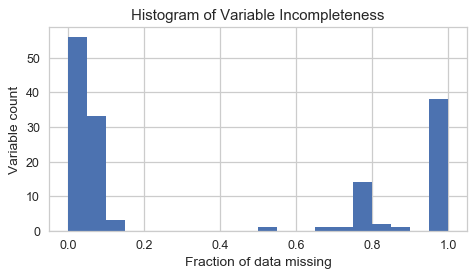

In [11]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Variable Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Variable count')

From the above histogram, we see there's a large gap between features missing "some" data and those missing "lots" of data. Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in a list:

In [12]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [13]:
len(drop_list)

58

Now drop these features.

In [14]:
loans.drop(labels=drop_list, axis=1, inplace=True)

## Remove features that were unavailable before the loan was funded
<a id="4.4"></a>

We examine the Lending Club Data Dictionary to determine which features would not have been available before the loan was funded. The idea here is to predict whether a loan will be paid off **before** deciding to fund the loan. Here's the list of features we currently have, in alphabetical order:

In [15]:
print(sorted(list(loans.columns)))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

For each of these features, we check the description in the Data Dictionary, and drop those features that we believe would not have been available before the loan was funded. When in doubt, we err on the side of dropping the feature.

In [16]:
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']

How many features will be dropped?

In [17]:
len(drop_list)

62

Drop these features:

In [18]:
loans.drop(labels=drop_list, axis=1, inplace=True)

## Inspect the remaining features

We'll inspect each feature individually, and do the following:

1. View summary statistics and visualize the data, if desired.
2. Modify the feature to make it useful for modeling, if necessary.
3. Drop the feature if it can't be made useful for modeling.

Define a plotting utility:

In [48]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charge Off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

How many features are left?

In [33]:
loans.shape[1]

29

What are the remaining features?

In [34]:
print(list(loans.columns))

['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'pub_rec', 'initial_list_status', 'policy_code', 'application_type', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies']


### id

Data Dictionary: "A unique [Lending Club] assigned ID for the loan listing."

In [35]:
loans['id'].sample(5)

KeyError: 'id'

 Are all the IDs in fact unique?

In [ ]:
loans['id'].describe()

The ID is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [ ]:
loans.drop('id', axis=1, inplace=True)

### loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [36]:
loans['loan_amnt'].describe()

count    814986.000000
mean      14315.458210
std        8499.799241
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$40,000, with a median of \$12,000.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


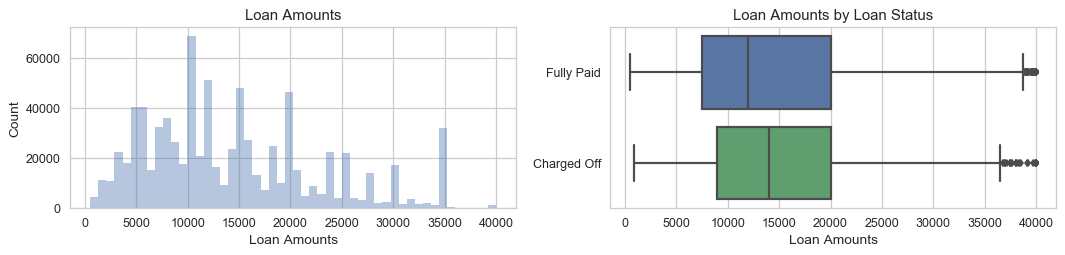

In [37]:
plot_var('loan_amnt', 'Loan Amounts', continuous=True)

Charged-off loans tend to have higher loan amounts. Because of the large number of samples, the difference in the medians is likely to be statistically significant.

### term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

Let's check the value counts:

In [38]:
loans['term'].value_counts(dropna=False)

36    618460
60    196526
Name: term, dtype: int64

Convert `term` to integers.

In [39]:
loans.loc[:,'term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

AttributeError: 'int' object has no attribute 'split'

In [ ]:
loans['term'].value_counts(normalize=True)

In [ ]:
plot_var('term', 'Term', continuous=False)

About 76% of loans are 36 months, and the rest are 60 months. Loans with 60-month terms are less likely to be fully paid.

### int_rate

Data Dictionary: "Interest Rate on the loan."

In [40]:
loans['int_rate'].describe()

count    814986.000000
mean         13.490993
std           4.618486
min           5.320000
25%           9.990000
50%          13.110000
75%          16.290000
max          30.990000
Name: int_rate, dtype: float64

Interest rates range from 5.3% to 30.9% (!), with a median of 13.1%.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


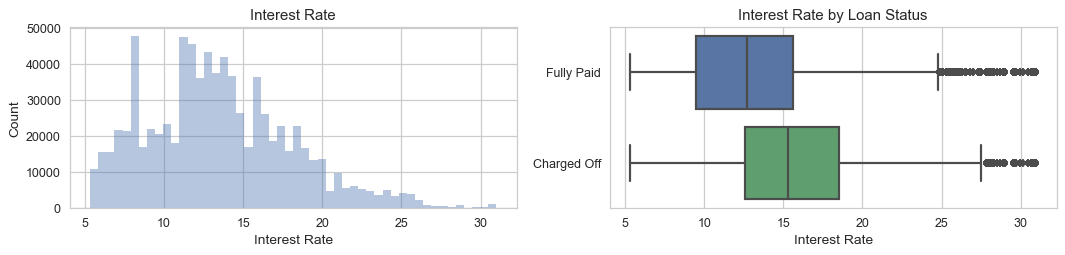

In [41]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have higher interest rates.

### installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [42]:
loans['installment'].describe()

count    814986.000000
mean        436.749624
std         255.732093
min           4.930000
25%         251.400000
50%         377.040000
75%         576.290000
max        1714.540000
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,714, with a median of \$377.

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


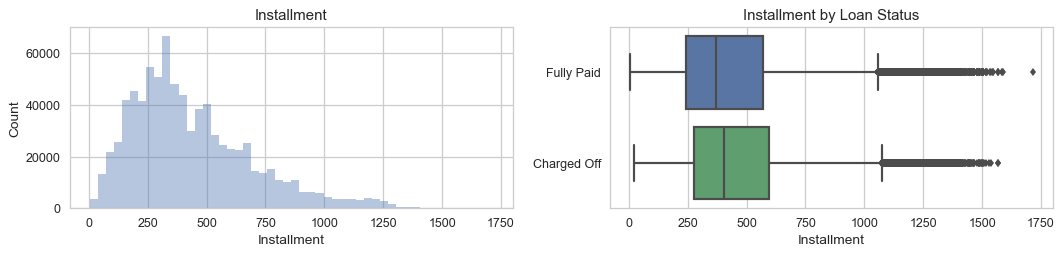

In [43]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have slightly higher installments.

### grade, sub_grade

Data Dictionary for `grade`: "[Lending Club] assigned loan grade."

Data Dictionary for `sub_grade`: "LC assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [44]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [45]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [46]:
loans.drop('grade', axis=1, inplace=True)

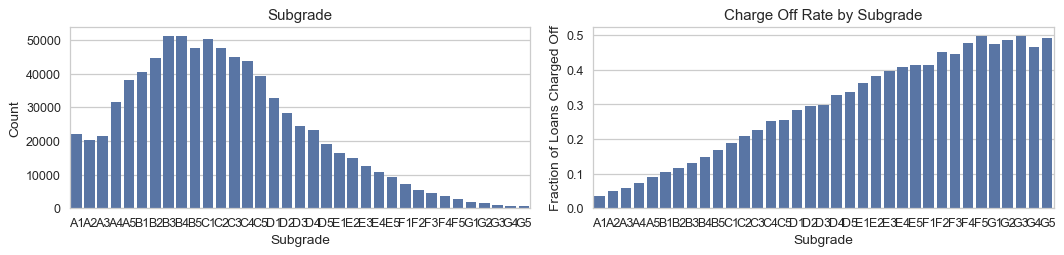

In [49]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

### emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [50]:
loans['emp_title'].describe()

count      766415
unique     280473
top       Teacher
freq        11351
Name: emp_title, dtype: object

In [51]:
loans.shape[0]

814986

There are too many different job titles for this feature to be useful, so we drop it.

In [52]:
loans.drop(labels='emp_title', axis=1, inplace=True)

### emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [53]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        53411
10+ years    264873
2 years       73493
3 years       64999
4 years       48752
5 years       52149
6 years       40290
7 years       39407
8 years       38887
9 years       31900
< 1 year      64572
NaN           42253
Name: emp_length, dtype: int64

Note there are 42,253 loans without data on the length of employment.

Convert `emp_length` to integers:

In [54]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [55]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [56]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [57]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [58]:
loans['emp_length'].value_counts(dropna=False).sort_index()

 0.0      64572
 1.0      53411
 2.0      73493
 3.0      64999
 4.0      48752
 5.0      52149
 6.0      40290
 7.0      39407
 8.0      38887
 9.0      31900
 10.0    264873
NaN       42253
Name: emp_length, dtype: int64

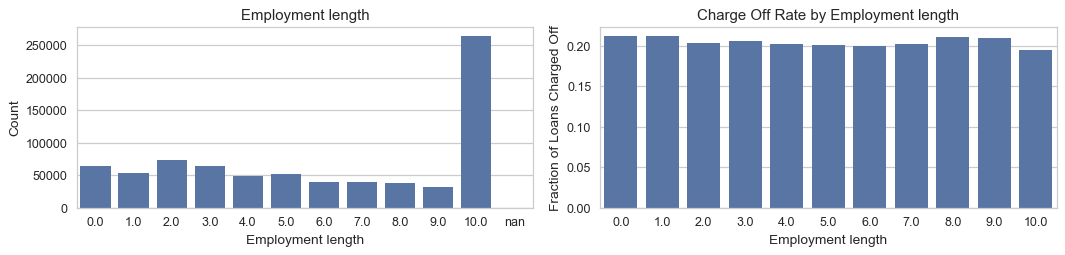

In [59]:
plot_var('emp_length', 'Employment length', continuous=False)

Loan status does not appear to depend much at all on employment length.

### home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [60]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

Replace ANY and NONE with OTHER, so that we have enough observations of each category.

In [61]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [62]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          284
Name: home_ownership, dtype: int64

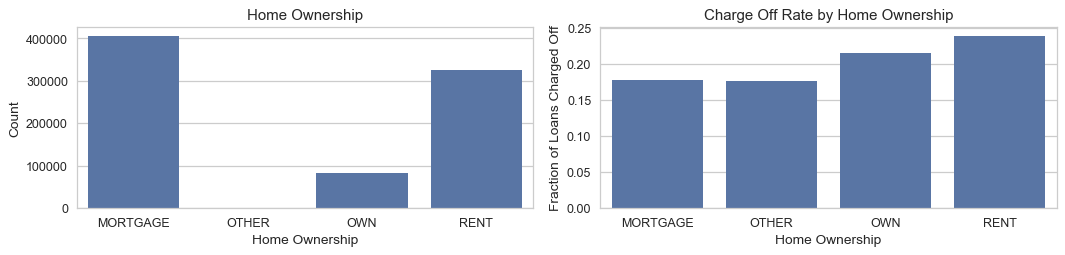

In [63]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be small differences in charge-off rates by home ownership status. Renters have slightly less probability of fully paying off the loan. Because of the large numbers of observations in each category, these differences are statistically significant.

### annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [64]:
loans['annual_inc'].describe()

count    8.149860e+05
mean     7.523039e+04
std      6.524373e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. (Note this is more than double the national median individual income in the US.)

Because of the large range of incomes, we should take a log transform of the annual income.

In [65]:
loans['annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [66]:
loans['annual_inc'].describe()

count    814986.000000
mean          4.810836
std           0.231893
min           0.000000
25%           4.653222
50%           4.812920
75%           4.954247
max           6.980003
Name: annual_inc, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


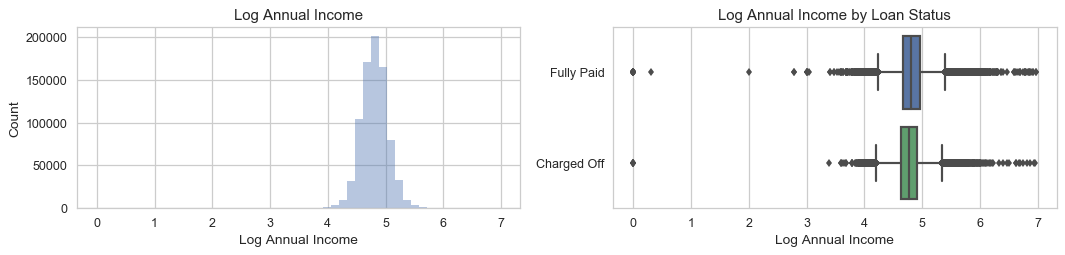

In [67]:
plot_var('annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with somewhat higher income are more likely to pay off their loans. Let's break this down:

In [68]:
loans.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,168084.0,4.777072,0.227015,0.0,4.632467,4.778158,4.915096,6.949393
Fully Paid,646902.0,4.819608,0.232342,0.0,4.672107,4.812920,4.963793,6.980003


There is a small, but likely statistically significant difference in the medians.

### verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [69]:
loans['verification_status'].value_counts(dropna=False)

Source Verified    293897
Verified           269895
Not Verified       251194
Name: verification_status, dtype: int64

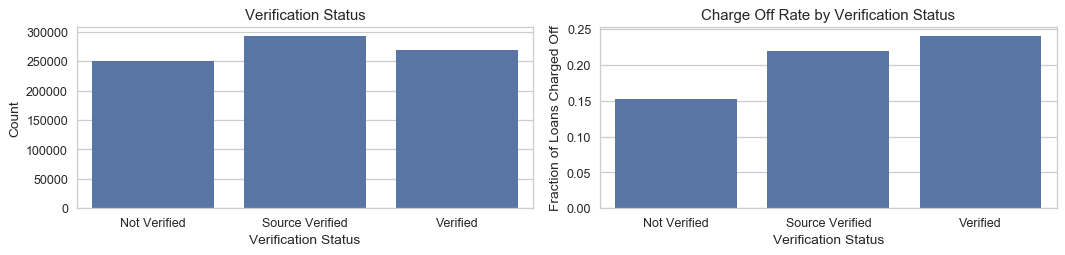

In [70]:
plot_var('verification_status', 'Verification Status', continuous=False)

### issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available before the loan was funded, `issue_d` will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

### purpose

Data Dictionary: "A category provided by the borrower for the loan request."

In [71]:
loans['purpose'].value_counts()

debt_consolidation    481652
credit_card           175123
home_improvement       50793
other                  43900
major_purchase         17463
small_business         10214
car                     8936
medical                 8772
moving                  5725
vacation                5116
house                   4095
wedding                 2272
renewable_energy         599
educational              326
Name: purpose, dtype: int64

Calculate the fully-paid rates by purpose:

In [74]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.121919
car                   0.148053
educational           0.171779
credit_card           0.178412
home_improvement      0.181383
major_purchase        0.183245
vacation              0.198788
house                 0.214652
other                 0.216970
debt_consolidation    0.217398
medical               0.229366
moving                0.242969
renewable_energy      0.247078
small_business        0.302428
Name: loan_status, dtype: float64

We see that, for example, 87.8% of loans for weddings are fully paid, but only 69.7% of small business loans are fully paid.

### title

Data Dictionary: "The loan title provided by the borrower."

In [75]:
loans['title'].sample(5)

373595     Debt consolidation
620686     Debt consolidation
919186               Loan One
383126       Home improvement
1169573    Debt consolidation
Name: title, dtype: object

In [76]:
loans['title'].describe()

count                 807068
unique                 60298
top       Debt consolidation
freq                  371874
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [77]:
loans['title'].value_counts().head(10)

Debt consolidation         371874
Credit card refinancing    133334
Home improvement            39171
Other                       33265
Debt Consolidation          15059
Major purchase              12311
Medical expenses             6908
Business                     6666
Car financing                5667
Consolidation                5090
Name: title, dtype: int64

There are 60,298 different purposes in the dataset, and based on the top 10 titles, the `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [78]:
loans.drop(labels='title', axis=1, inplace=True)

### zip_code, addr_state

Data Dictionary for `zip_code`: "The first 3 numbers of the zip code provided by the borrower in the loan application."

Data Dictionary for `addr_state`: "The state provided by the borrower in the loan application."

In [79]:
loans['zip_code'].sample(5)

1408152    802xx
583920     356xx
439802     386xx
818143     105xx
905424     752xx
Name: zip_code, dtype: object

In [80]:
loans['zip_code'].nunique()

925

In [81]:
loans['addr_state'].sample(5)

573003     VA
264458     CA
1365554    MS
10942      NJ
187304     TX
Name: addr_state, dtype: object

In [82]:
loans['addr_state'].nunique()

51

There are a lot of different zip codes, so let's just retain the state column.

In [83]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the fully-paid rates by address state:

In [85]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.130378
ME    0.136564
NH    0.142554
IA    0.142857
VT    0.149225
OR    0.152827
CO    0.158083
WA    0.166538
KS    0.171004
SC    0.172705
WI    0.175315
MT    0.177759
WY    0.178142
UT    0.179049
WV    0.182457
CT    0.183810
GA    0.191224
MA    0.192974
IL    0.193302
ID    0.193487
RI    0.194009
CA    0.198303
AZ    0.199321
TX    0.202286
AK    0.204141
HI    0.204535
DE    0.206575
VA    0.207942
MI    0.208880
MN    0.210363
PA    0.214776
MD    0.214845
NC    0.215282
NJ    0.216208
KY    0.216353
MO    0.219400
FL    0.222007
OH    0.225400
NM    0.225694
SD    0.225787
NY    0.227045
IN    0.228179
TN    0.230479
NV    0.234202
ND    0.237232
LA    0.237900
AR    0.243154
AL    0.247650
OK    0.248252
NE    0.267946
MS    0.275619
Name: loan_status, dtype: float64

The percentages of loans fully paid ranges from 72.4% in Mississippi to 86.9% in Washington, DC.

### dti

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [86]:
loans['dti'].describe()

count    814950.000000
mean         17.867719
std           8.856477
min          -1.000000
25%          11.640000
50%          17.360000
75%          23.630000
max         999.000000
Name: dti, dtype: float64

Note sure if the values of -1 and 999 make sense...

There are several outliers that mess up our default plots. Plot a histogram for `dti` less than 60:

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Debt-to-income')

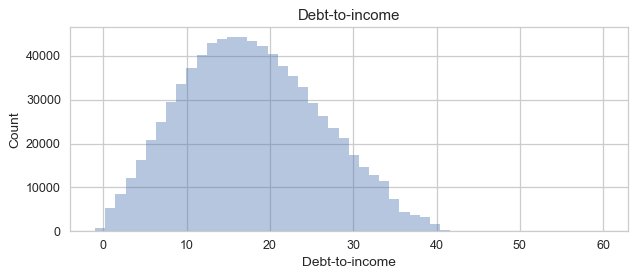

In [87]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income')
plt.ylabel('Count')
plt.title('Debt-to-income')

How many of the `dti` values are "outliers" (above 60)?

In [88]:
(loans['dti']>=60).sum()

179

Very few.

Compare the `dti` medians for fully paid and charged-off loans:

In [89]:
loans.groupby('loan_status')['dti'].median()

loan_status
Charged Off    19.77
Fully Paid     16.77
Name: dti, dtype: float64

Borrowers who charge off tend to have higher debt-to-income ratios.

### earliest_cr_line

Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [90]:
loans['earliest_cr_line'].sample(5)

111882    Dec-2004
292796    Jan-2007
389813    Jun-2004
40685     May-1999
413070    Oct-1982
Name: earliest_cr_line, dtype: object

In [91]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [92]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [93]:
loans['earliest_cr_line'].describe()

count    814986.000000
mean       1998.170962
std           7.385629
min        1944.000000
25%        1994.000000
50%        2000.000000
75%        2003.000000
max        2014.000000
Name: earliest_cr_line, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


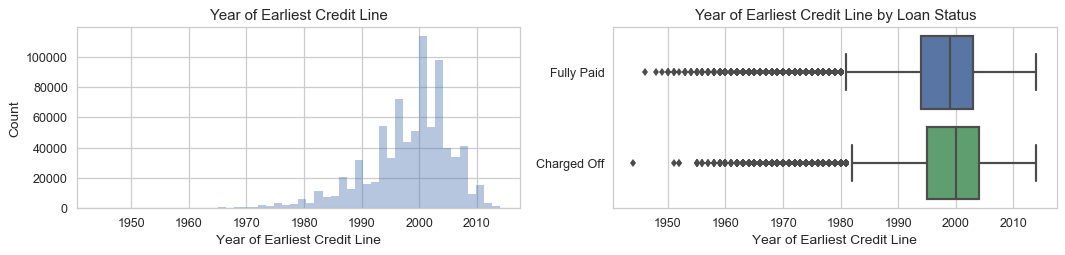

In [94]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who charge off tend to have opened their first credit line more recently.

### fico_range_low, fico_range_high

Data Dictionary for `fico_range_low`: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for `fico_range_high`: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [95]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,814986.000000,814986.000000
mean,695.603151,699.603264
std,31.352251,31.352791
min,625.000000,629.000000
25%,670.000000,674.000000
50%,690.000000,694.000000
75%,710.000000,714.000000
max,845.000000,850.000000


Check the correlation between these values:

In [96]:
loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


We only need to keep one of the FICO scores.

In [97]:
loans.drop(labels='fico_range_low', axis=1, inplace=True)

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


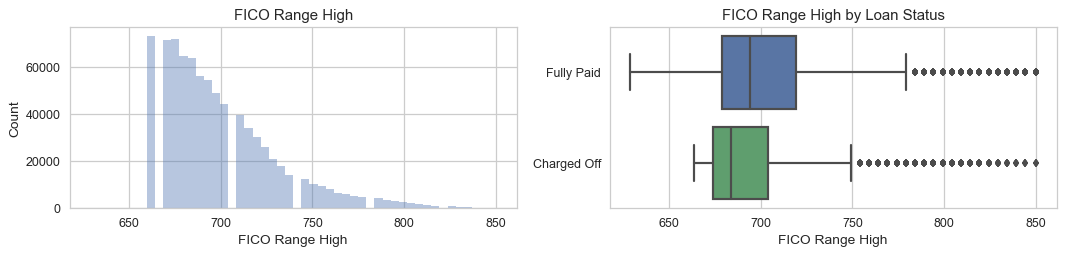

In [98]:
plot_var('fico_range_high', 'FICO Range High', continuous=True)

There is a noticeable difference in FICO scores between fully paid and charged-off loans.

### pub_rec

Data Dictionary: "Number of derogatory public records."

In [99]:
loans['pub_rec'].value_counts()

0.0     681509
1.0     112483
2.0      14115
3.0       4107
4.0       1400
5.0        651
6.0        338
7.0        146
8.0         90
9.0         42
10.0        28
11.0        24
12.0        15
13.0        11
15.0         5
18.0         3
16.0         2
19.0         2
14.0         2
49.0         2
28.0         2
34.0         1
24.0         1
46.0         1
54.0         1
63.0         1
17.0         1
21.0         1
86.0         1
40.0         1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [100]:
loans.groupby('loan_status')['pub_rec'].mean()

loan_status
Charged Off    0.232247
Fully Paid     0.198845
Name: pub_rec, dtype: float64

### initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." I'm not sure what this means.

In [101]:
loans['initial_list_status'].value_counts()

f    413678
w    401308
Name: initial_list_status, dtype: int64

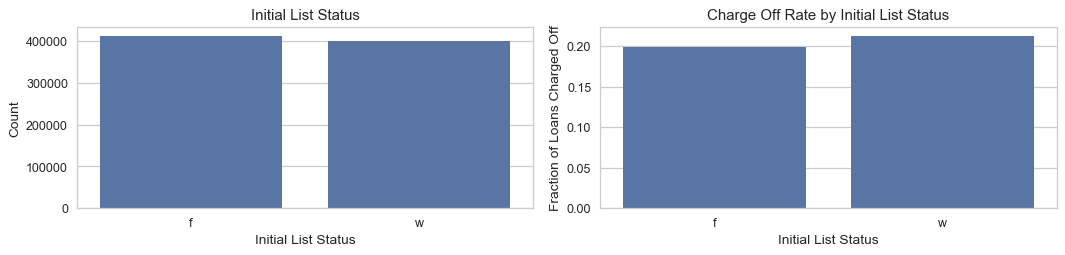

In [102]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

### policy_code

Data Dictionary: "publicly available policy_code=1; new products not publicly available policy_code=2"

In [105]:
loans['policy_code'].value_counts()

KeyError: 'policy_code'

All values are the same; drop this variable.

In [104]:
loans.drop(labels='policy_code', axis=1, inplace=True)

### application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [106]:
loans['application_type'].value_counts()

Individual    811207
Joint App       3779
Name: application_type, dtype: int64

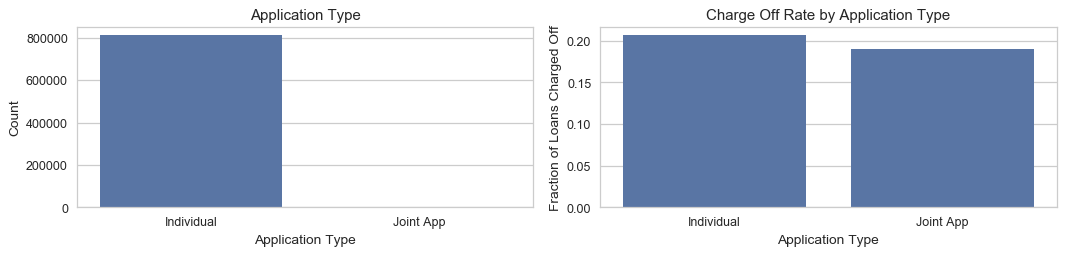

In [107]:
plot_var('application_type', 'Application Type', continuous=False)

Joint loans are slightly more likely to be fully paid, but because there are few joint apps, it's unclear at the moment whether the difference is statistically significant.

### mo_sin_old_il_acct

Data Dictionary: "Months since oldest bank installment account opened."

In [108]:
loans['mo_sin_old_il_acct'].describe()

count    725427.000000
mean        125.926232
std          51.554620
min           0.000000
25%          98.000000
50%         129.000000
75%         152.000000
max         724.000000
Name: mo_sin_old_il_acct, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


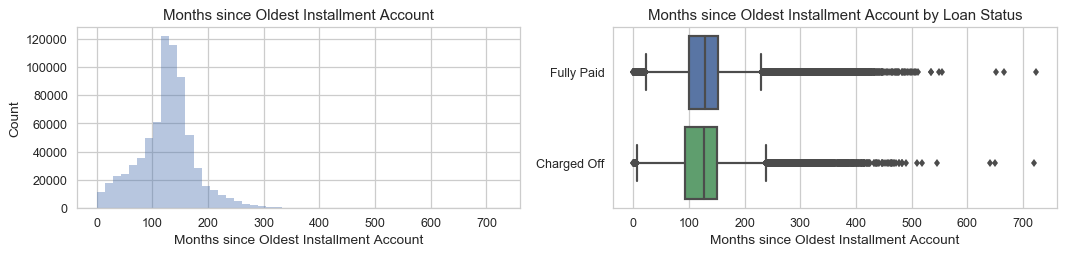

In [109]:
plot_var('mo_sin_old_il_acct', 'Months since Oldest Installment Account', continuous=True)

### mo_sin_old_rev_tl_op

Data Dictionary: "Months since oldest revolving account opened."

In [110]:
loans['mo_sin_old_rev_tl_op'].describe()

count    747458.000000
mean        180.843182
std          92.192939
min           2.000000
25%         117.000000
50%         164.000000
75%         228.000000
max         842.000000
Name: mo_sin_old_rev_tl_op, dtype: float64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


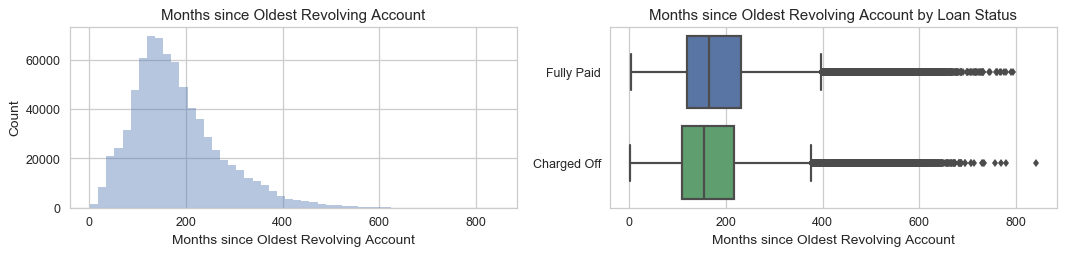

In [111]:
plot_var('mo_sin_old_rev_tl_op', 'Months since Oldest Revolving Account', continuous=True)

### mort_acc

Data Dictionary: "Number of mortgage accounts."

In [112]:
loans['mort_acc'].describe()

count    767705.000000
mean          1.758707
std           2.081730
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64

Not sure how someone can have 51 mortgage accounts...but apparently they do.

Top 10 values:

In [113]:
loans['mort_acc'].value_counts().head(10)

0.0    301446
1.0    131811
2.0    109869
3.0     82723
4.0     58698
5.0     37090
6.0     21817
7.0     11568
8.0      5906
9.0      3056
Name: mort_acc, dtype: int64

C:\Users\Joe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


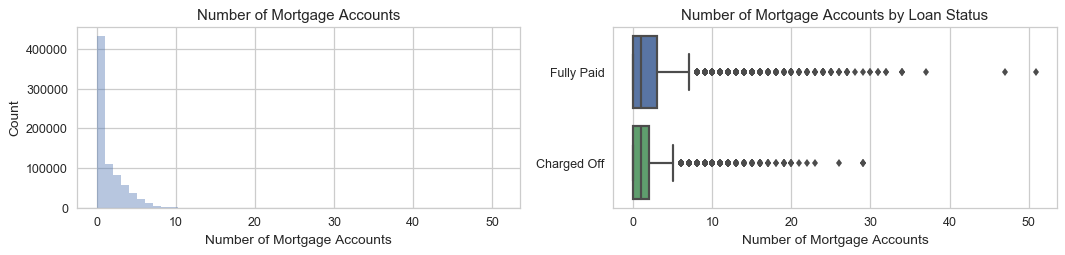

In [114]:
plot_var('mort_acc', 'Number of Mortgage Accounts', continuous=True)

Compare the averages by loan status:

In [115]:
loans.groupby('loan_status')['mort_acc'].mean()

loan_status
Charged Off    1.447437
Fully Paid     1.841436
Name: mort_acc, dtype: float64

Individuals who pay off their loans tend to have more mortgage accounts on average.

### pub_rec_bankruptcies

Data Dictionary: "Number of public record bankruptcies."

In [116]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.0     714642
1.0      93680
2.0       4673
3.0        926
4.0        234
5.0         85
6.0         28
7.0         14
8.0          5
9.0          1
12.0         1
Name: pub_rec_bankruptcies, dtype: int64

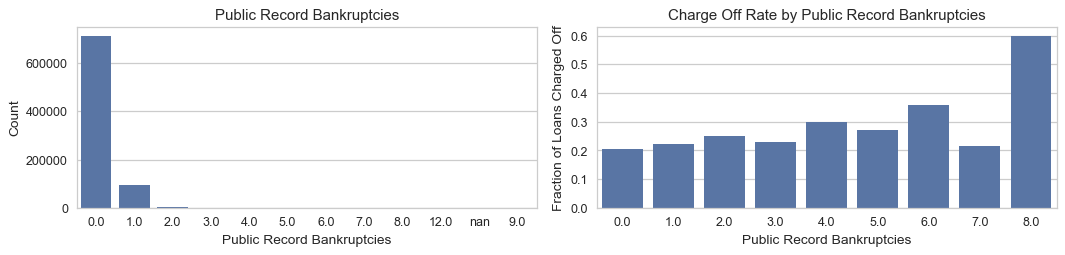

In [117]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

# More Pre-processing

## Convert Loan Status to Binary

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [118]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

## Create Dummy Variables

How many variables do we currently have?

In [119]:
loans.shape[1]

23

Which variables have missing values?

In [120]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

In [121]:
missing_fractions[missing_fractions > 0]

mo_sin_old_il_acct      0.109890
mo_sin_old_rev_tl_op    0.082858
mort_acc                0.058014
emp_length              0.051845
pub_rec_bankruptcies    0.000855
dti                     0.000044
dtype: float64

There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [122]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

In [123]:
loans.shape

(814986, 120)

Check our data with the new dummy variables:

In [124]:
loans.sample(3)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,issue_d,dti,earliest_cr_line,fico_range_high,pub_rec,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
985594,26500.0,36,18.25,961.37,NaN,4.730467,Mar-2012,20.47,1999,679.0,0.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
616771,13200.0,60,14.65,311.61,10.0,4.929424,Mar-2015,11.34,2000,664.0,0.0,167.0,171.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
266006,5325.0,36,10.62,173.38,0.0,4.676556,May-2010,15.95,2002,709.0,0.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Looks good!

## Train/test split

We'll make our predictions more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict the outcome of loans funded on later dates.

The variable `issue_d` includes the month which the loan was funded. Let's peek at this variable:

In [125]:
loans['issue_d'].sample(5)

885969    Jun-2013
871255    Aug-2013
964452    Sep-2012
130614    Jul-2014
873054    Aug-2013
Name: issue_d, dtype: object

So `issue_d` only includes month and year data. Are there any missing values?

In [126]:
loans['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [127]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [128]:
loans['issue_d'].sample(5)

1384687   2016-04-01
1472774   2016-11-01
964957    2012-08-01
967562    2012-08-01
154202    2014-05-01
Name: issue_d, dtype: datetime64[ns]

The `issue_d` values got converted to dates, all on the first day of the month. Check summary statistics of the issue dates:

In [129]:
loans['issue_d'].describe()

count                  814986
unique                    124
top       2014-10-01 00:00:00
freq                    33699
first     2007-06-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

Note there are only 124 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in September 2017. The busiest month was October 2014 with 33,699 loans funded in that month. What is the distribution of loans funded per year?

Text(0.5,1,'Loans Funded per Year')

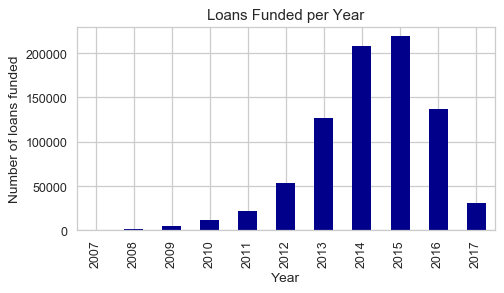

In [130]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of loans funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [131]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [132]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    814986
Number of loans in the full dataset: 814986


The partition looks good, so we can delete the original `loans` dataframe.

In [133]:
del loans

Let's look at the summary statistics of the issue dates in the train/validation/test sets:

In [134]:
loans_train['issue_d'].describe()

count                  731108
unique                    109
top       2014-10-01 00:00:00
freq                    33699
first     2007-06-01 00:00:00
last      2016-06-01 00:00:00
Name: issue_d, dtype: object

In [135]:
loans_test['issue_d'].describe()

count                   83878
unique                     15
top       2016-07-01 00:00:00
freq                    10825
first     2016-07-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from June 2007 to June 2016. The test set includes loans from July 2016 to September 2017.

Now we can delete the `issue_d` variable, because it was not available before the loan was funded.

In [136]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the response variable:

In [137]:
X_train = loans_train.drop('charged_off', axis=1)
y_train = loans_train.loc[:, 'charged_off']
X_test = loans_test.drop('charged_off', axis=1)
y_test = loans_test.loc[:, 'charged_off']

In [138]:
del loans_train, loans_test

## Imputation with mean substitution
<a id="7.2"></a>

How complete is our training data?

In [139]:
missing_fractions = X_train.isnull().mean().sort_values(ascending=False)

In [140]:
missing_fractions[missing_fractions > 0]

mo_sin_old_il_acct      0.120044
mo_sin_old_rev_tl_op    0.092364
mort_acc                0.064670
emp_length              0.050586
pub_rec_bankruptcies    0.000953
dti                     0.000014
dtype: float64

We cannot have any missing data for the models that we'll train. Perform mean substitution, using only the means of the training set to prevent test set leakage.

In [141]:
from sklearn.preprocessing import Imputer

In [142]:
imputer = Imputer(copy=False)

In [143]:
imputer.fit(X_train)

Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)

In [144]:
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(imputer.transform(X_test),  columns=X_test.columns)

## Standardize the data
<a id="7.3"></a>

Shift and scale each column individually so that it has zero mean and unit variance. This step is necessary to perform regularization.

Train the scaler using only the training data to prevent test set leakage.

In [145]:
from sklearn.preprocessing import StandardScaler

In [146]:
scaler = StandardScaler(copy=False)

In [147]:
scaler.fit(X_train)

StandardScaler(copy=False, with_mean=True, with_std=True)

In [148]:
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

## Automatic feature selection

In [149]:
# from sklearn.feature_selection import SelectKBest, mutual_info_classif

# selector = SelectKBest(mutual_info_classif, k=15)

# selector.fit(X_train.iloc[1:50000], y_train.iloc[1:50000])

# X_train.shape

# X_test.shape

# X_train = selector.transform(X_train)
# X_test  = selector.transform(X_test)

# X_train.shape

# X_test.shape

# Statistical Modeling
<a id="8"></a>

In [150]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

## SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
model_sgdlogreg = SGDClassifier(loss='log', penalty='l1', max_iter=1000, tol=1e-3, random_state=1, warm_start=True)

In [ ]:
model_sgdlogreg_cvscores = cross_val_score(estimator=model_sgdlogreg, X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=-1, pre_dispatch=8)

In [ ]:
print(model_sgdlogreg_cvscores)
print(model_sgdlogreg_cvscores.mean())

## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

In [ ]:
model_rfc_cvscores = cross_val_score(estimator=model_rfc, X=X_train, y=y_train, scoring='roc_auc', cv=5, n_jobs=-1, pre_dispatch=8)

In [ ]:
print(model_rfc_cvscores)
print(model_rfc_cvscores.mean())

I decided to use a SGD Classifier by looking at the machine learning flowchart here: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html.

The SGDClassifier estimator implements linear classifiers (SVM, logistic regression, a.o.) with SGD training. The linear classifier is chosen by the `loss` hyperparameter.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

## Train with grid search
<a id="8.1"></a>

We're going to search through many hyperparameters of SGDClassifier using an exhaustive grid search with 3-fold cross-validation, implemented in GridSearchCV.

Here are the hyperparameters that we'll try:

In [ ]:
param_grid = {'alpha': [10.0**k for k in range(-3, 3)],
              'penalty': ['l1', 'l2']}

Instantiate the grid estimator. We'll use the Matthews correlation coefficient as our scoring metric.

In [ ]:
grid = GridSearchCV(estimator=SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=random_state, warm_start=True), param_grid=param_grid, scoring=make_scorer(matthews_corrcoef), n_jobs=4, pre_dispatch=8, cv=5, verbose=1)

Run the grid search (this could take some time).

In [ ]:
grid.fit(X_train, y_train)

Hyperparameters that gave the best results on the hold out data:

In [ ]:
grid.best_params_

Mean cross-validated MCC score of the best estimator:

In [ ]:
grid.best_score_

Weights assigned to the features by the best estimator:

In [ ]:
plt.figure(figsize=(6,4), dpi=90)
sns.barplot(y=np.arange(0,15), x=grid.best_estimator_.coef_[0,:], orient='h')
plt.title("Classifier Weights")
plt.xlabel("classifier weight")

## Test set evaluation
<a id="8.2"></a>

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

In [ ]:
def classification_eval(estimator, X_test, y_test):
    """
    Print several metrics of classification performance of an estimator, given features X_test and true labels y_test.
    
    Input: estimator or GridSearchCV instance, X_test, y_test
    Returns: text printout of metrics
    """
    y_pred = estimator.predict(X_test)
    
    # Number of decimal places based on number of samples
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    print('Confusion matrix')
    print(confusion_matrix(y_test, y_pred), '\n')
    
    print('Classification report')
    print(classification_report(y_test, y_pred, digits=dec))
    
    print('Scalar metrics')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    if y_test.nunique() <= 2: # Additional metrics for binary classification
        try:
            y_score = estimator.predict_proba(X_test)[:,1]
        except:
            y_score = estimator.decision_function(X_test)
        print(format_str % ('AUPRC', average_precision_score(y_test, y_score)))
        print(format_str % ('AUROCC', roc_auc_score(y_test, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))
    # Add Informedness
    # Add Markedness
    # Add Fleiss' kappa

Test set evaluation metrics:

In [ ]:
classification_eval(grid, X_test, y_test)